# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 274 kB 5.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c4647a31d2d321e54a5617150fa891532c786482f989ccc9c99e3d074cd2848f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [1]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
#assert torch.__version__.startswith("1.7")
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-cc_q5rt3
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-cc_q5rt3
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.5.post20211023.tar.gz (49 kB)
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached omegaconf-2.1.1-py3-none-any.whl (74 kB)
  Using cached hydra_core-1.1.1-py3-none-any.whl (145 kB)
  Using cached black-21.4b2-py3-none-any.whl (130 kB)
  Using cached typed_ast-1.4.3-cp37-cp37m-manylinux1_x86_64.whl (743 kB)
  Using cached pathspec-0.9.0-py2.py3-none-any.whl (31 kB)
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
  Using cached regex-2021.11.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (749 kB)
  Using cached antlr4-python3-runtime-4.8.tar.gz (112 kB)
  Using cached portalocker-2.3.2-py2.py3-none-any.whl (15 kB)
  Created wheel for detectron2: filename=detectron2-0

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Registration of the custom dataset to detectron2

In [16]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/682_Project/ShipDetection/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [17]:
# Global paths
datasets = '/content/drive/MyDrive/682_Project/ShipDetection/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    #DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [20]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Training on a custom dataset
*Change Runtime to GPU before running*

In [21]:
%cd /content/drive/MyDrive/682_Project/ShipDetection/SSDD/
output = '/content/drive/MyDrive/682_Project/ShipDetection/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_3"

/content/drive/.shortcut-targets-by-id/1Sc564UmRZ5RHEkc3WxVO95NAEEEAl_km/682_Project/ShipDetection/SSDD


In [22]:
!pwd

/content/drive/.shortcut-targets-by-id/1Sc564UmRZ5RHEkc3WxVO95NAEEEAl_km/682_Project/ShipDetection/SSDD


In [23]:
from detectron2.engine import DefaultTrainer
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 72000   # 24 epochs * 6000 images / 2 images per batch = 72,000 iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # 128 is faster, and good enough for a toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1   # only has one class (ship). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training examples without annotations

In [14]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_R_101_FPN_3x_3'

In [24]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/03 18:22:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:08, 28.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[11/03 18:22:49 d2.engine.train_loop]: Starting training from iteration 0
ERROR [11/03 18:22:49 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/defaults.py", line 495, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 267, in run_step
    data = next(self._data_loader_iter)
  File "/usr/local/lib/python3.7/dist-packages/detectron2/data/common.py", line 234, in __iter__
    for d in self.dataset:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3

FileNotFoundError: ignored

In [ ]:
%ls ./ModelOutput/faster_rcnn_R_101_FPN_3x_3

events.out.tfevents.1613244947.e760dfe8162a.148.0  model_0039999.pth
last_checkpoint                                    model_0044999.pth
metrics.json                                       model_0049999.pth
model_0004999.pth                                  model_0054999.pth
model_0009999.pth                                  model_0059999.pth
model_0014999.pth                                  model_0064999.pth
model_0019999.pth                                  model_0069999.pth
model_0024999.pth                                  model_final.pth
model_0029999.pth                                  _param.txt
model_0034999.pth


# TensorBoard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_R_101_FPN_3x_3
%cd ..

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # 0.7
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5   # pg. 23 of Zhang et al.

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [ ]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [ ]:
os.makedirs(model_name + "/predImages", exist_ok=True)  # Make a directory for output images

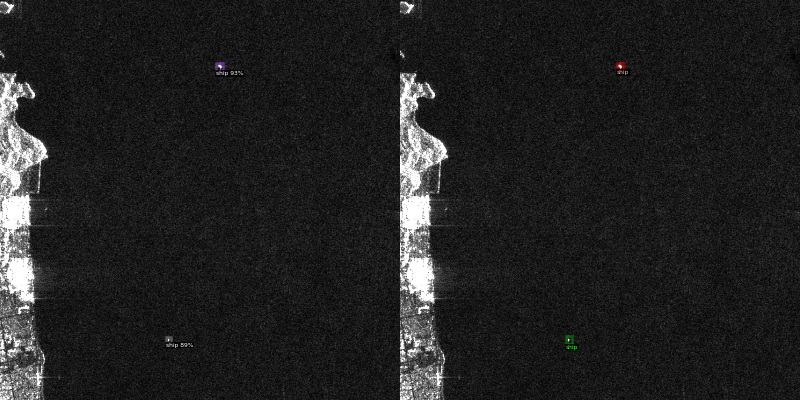

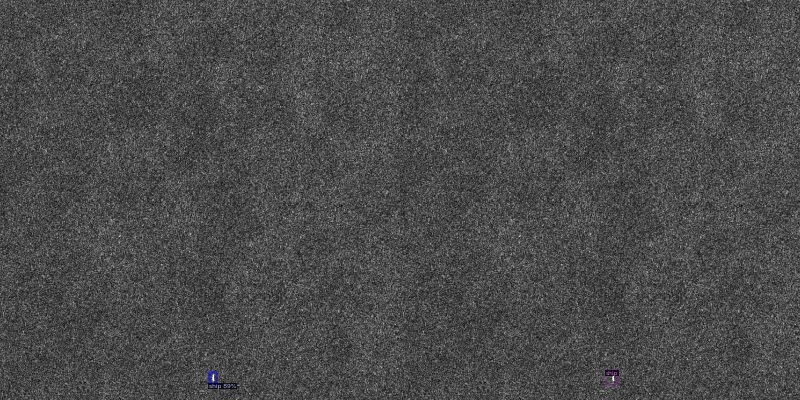

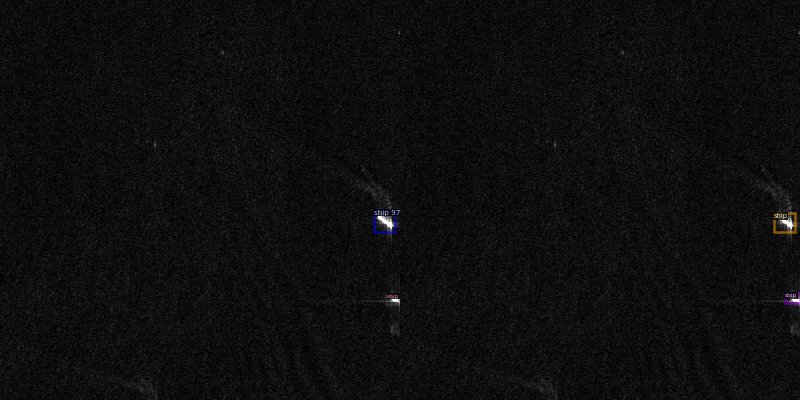

In [ ]:
from cv2 import hconcat
#random.seed(2)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3)  # display an image
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Prediction

We can also evaluate its performance using AP metric implemented in COCO API.

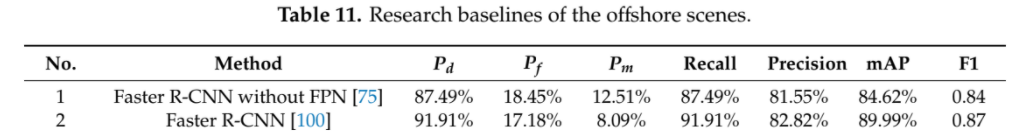

In [ ]:
#val = './datasets/test/'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/14 05:12:08 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/14 05:12:08 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_offshore' to COCO format ...)
[02/14 05:12:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/14 05:12:26 d2.data.datasets.coco]: Conversion finished, #images: 2234, #annotations: 1495
[02/14 05:12:26 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_3/ssdd_test_offshore_coco_format.json' ...
[02/14 05:12:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[02/14 05:12:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[0

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/14 05:22:27 d2.evaluation.coco_evaluation]: 'ssdd_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/14 05:22:27 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test' to COCO format ...)
[02/14 05:22:27 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/14 05:22:27 d2.data.datasets.coco]: Conversion finished, #images: 3000, #annotations: 2378
[02/14 05:22:27 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_3/ssdd_test_coco_format.json' ...
[02/14 05:22:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[02/14 05:22:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/14 05:22:27 d2.data.commo

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/14 05:29:59 d2.evaluation.coco_evaluation]: 'ssdd_test_inshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/14 05:29:59 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_inshore' to COCO format ...)
[02/14 05:30:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/14 05:30:06 d2.data.datasets.coco]: Conversion finished, #images: 766, #annotations: 883
[02/14 05:30:06 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_3/ssdd_test_inshore_coco_format.json' ...
[02/14 05:30:06 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[02/14 05:30:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/14 

In [ ]:
# train
evaluator = COCOEvaluator('ssdd_train', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_train')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

NameError: ignored

In [ ]:
%ls ./ModelOutput/faster_rcnn_R_101_FPN_3x_3

ls: cannot access './ModelOutput/faster_rcnn_R_101_FPN_3x_3': No such file or directory
